# Анализ динамики диска на аэростоле

**Данные:** акселерометр + гироскоп (чип на диске), 50 Гц, 20 с записи  
**Установка:** диск плавает на воздушной подушке по поверхности аэростола. По краям натянуты струны, обеспечивающие упругое столкновение диска с краями.

**Цель:** извлечь количественные характеристики:
1. Модель вращательного трения
2. Параметры столкновений со струнами
3. Динамика поступательного движения
4. Направления ударов в лабораторной системе координат


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
    'figure.figsize': (12, 4), 'figure.dpi': 120,
    'axes.grid': True, 'grid.alpha': 0.3, 'font.size': 10,
})


## 1. Загрузка и обзор данных

In [2]:
df = pd.read_csv('4.csv')
print(f"Размер: {df.shape[0]} отсчётов, dt = {np.median(np.diff(df['time_s'])):.3f} с (50 Гц)")
print(f"Длительность записи: {df['time_s'].iloc[-1]:.1f} с")
print(f"Столбцы: {list(df.columns)}")
print("  ax, ay, az — ускорения в единицах g (система координат диска)")
print("  gx, gy, gz — угловые скорости в градусах/с")
df.head(10)


Размер: 1000 отсчётов, dt = 0.020 с (50 Гц)
Длительность записи: 20.0 с
Столбцы: ['time_s', 'ax_g', 'ay_g', 'az_g', 'gx_dps', 'gy_dps', 'gz_dps']
  ax, ay, az — ускорения в единицах g (система координат диска)
  gx, gy, gz — угловые скорости в градусах/с


,time_s,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps
0,0.00,0.031720,0.007808,-0.976488,1.33,-2.94,0.42
1,0.02,0.029768,0.007808,-0.973560,1.68,-3.01,0.42
2,0.04,0.034648,0.008784,-0.977464,1.54,-3.08,0.14
3,0.06,0.033672,0.005856,-0.982344,1.75,-3.22,0.00
4,0.08,0.032696,0.002440,-0.975512,1.40,-2.94,-0.14
5,0.10,0.034160,-0.001464,-0.981856,1.47,-2.80,-2.45
6,0.12,0.036112,-0.006344,-0.984296,2.03,-3.01,-5.39
7,0.14,0.084912,-0.100528,-0.979416,3.29,-2.38,-6.58
8,0.16,0.005368,0.042944,-0.982832,0.14,-3.29,-4.13
9,0.18,0.027328,-0.051728,-0.977464,3.15,-2.24,-23.10


## 2. Обзорные графики

<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_98/909102711.py:16: SyntaxWarning: invalid escape sequence '\o'
  axes[2].set_ylabel('$\omega_z$, grad/s')
/tmp/ipykernel_98/909102711.py:18: SyntaxWarning: invalid escape sequence '\o'
  axes[2].set_title('Угловая скорость $\omega_z$')


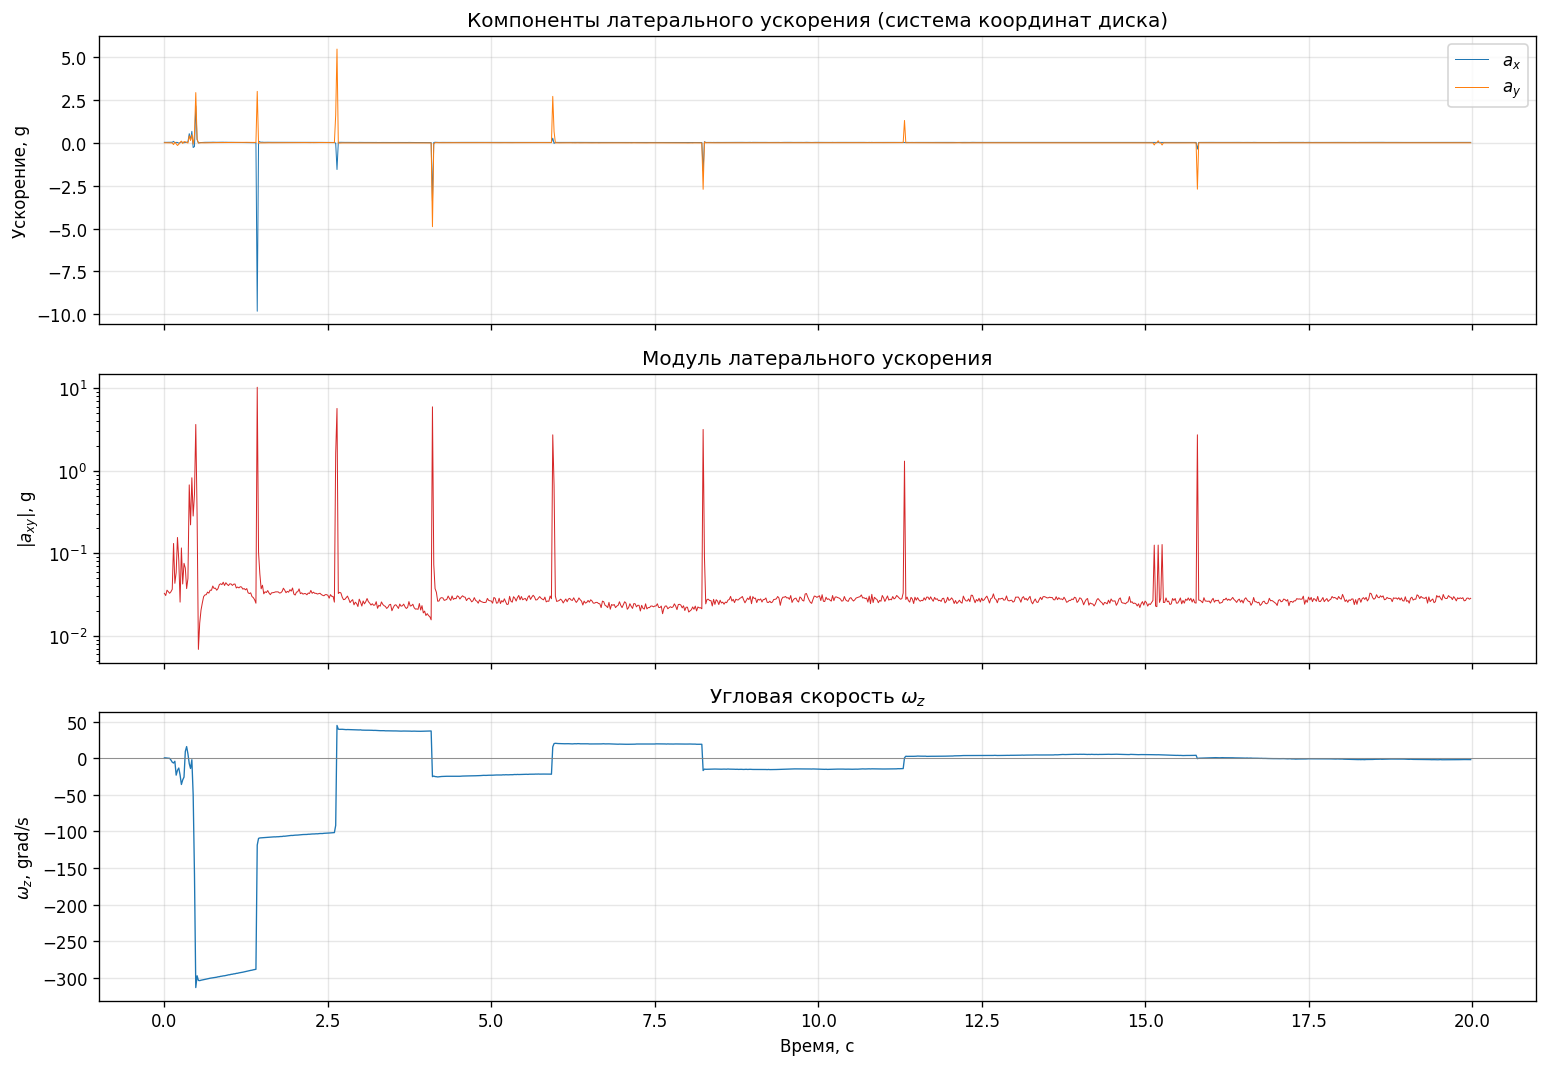

In [3]:
df['a_xy'] = np.sqrt(df['ax_g']**2 + df['ay_g']**2)

fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True)
axes[0].plot(df['time_s'], df['ax_g'], lw=0.6, label='$a_x$')
axes[0].plot(df['time_s'], df['ay_g'], lw=0.6, label='$a_y$')
axes[0].set_ylabel('Ускорение, g')
axes[0].set_title('Компоненты латерального ускорения (система координат диска)')
axes[0].legend()

axes[1].plot(df['time_s'], df['a_xy'], lw=0.6, color='C3')
axes[1].set_ylabel('$|a_{xy}|$, g')
axes[1].set_title('Модуль латерального ускорения')
axes[1].set_yscale('log')

axes[2].plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0')
axes[2].set_ylabel('$\omega_z$, grad/s')
axes[2].set_xlabel('Время, с')
axes[2].set_title('Угловая скорость $\omega_z$')
axes[2].axhline(0, color='gray', lw=0.5)
plt.tight_layout(); plt.show()


## 3. Детекция столкновений

In [4]:
def detect_collisions(df, threshold=0.5, merge_gap=3):
    mask = df['a_xy'] > threshold
    indices = df.index[mask].tolist()
    if not indices: return []
    groups = [[indices[0]]]
    for i in range(1, len(indices)):
        if indices[i] - indices[i-1] <= merge_gap:
            groups[-1].append(indices[i])
        else:
            groups.append([indices[i]])
    return groups

all_events = detect_collisions(df, threshold=0.5)
print(f"Обнаружено {len(all_events)} событий (|a_xy| > 0.5 g)")

# Первое событие — запуск рукой, исключаем
launch_event = all_events[0]
collisions = all_events[1:]
print(f"  Событие #1 (t ~ {df.loc[launch_event[0], 'time_s']:.2f} с) — запуск рукой, исключён")
print(f"  Столкновений со струнами: {len(collisions)}")


Обнаружено 8 событий (|a_xy| > 0.5 g)
  Событие #1 (t ~ 0.38 с) — запуск рукой, исключён
  Столкновений со струнами: 7


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_98/4219671536.py:2: SyntaxWarning: invalid escape sequence '\o'
  ax.plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0', label='$\omega_z$')
/tmp/ipykernel_98/4219671536.py:11: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('Время, с'); ax.set_ylabel('$\omega_z$, grad/s')


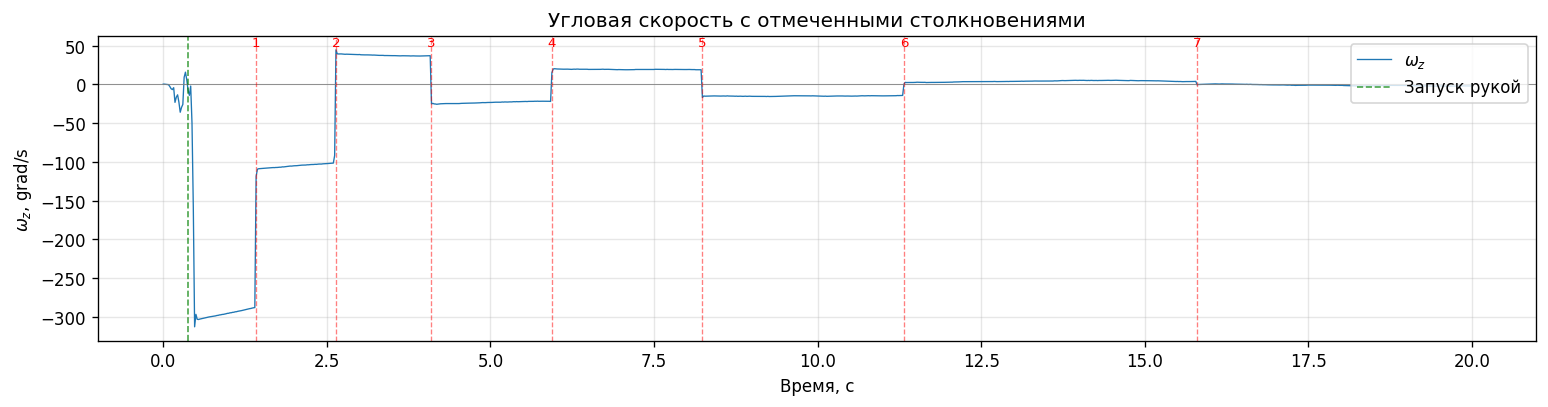

In [5]:
fig, ax = plt.subplots(figsize=(13, 3.5))
ax.plot(df['time_s'], df['gz_dps'], lw=0.8, color='C0', label='$\omega_z$')
ax.axhline(0, color='gray', lw=0.5)
launch_t = df.loc[launch_event[0], 'time_s']
ax.axvline(launch_t, color='green', ls='--', lw=1, alpha=0.7, label='Запуск рукой')
for i, grp in enumerate(collisions):
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    t = df.loc[peak_idx, 'time_s']
    ax.axvline(t, color='red', ls='--', lw=0.8, alpha=0.5)
    ax.text(t, 50, f'{i+1}', ha='center', fontsize=8, color='red')
ax.set_xlabel('Время, с'); ax.set_ylabel('$\omega_z$, grad/s')
ax.set_title('Угловая скорость с отмеченными столкновениями')
ax.legend(loc='upper right'); plt.tight_layout(); plt.show()


## 4. Пересчёт ускорений в лабораторную систему координат

Акселерометр измеряет ускорения в **подвижной системе координат диска**, которая вращается.
Между столкновениями диск поворачивается на сотни градусов, поэтому направления ускорений в СК диска 
**нельзя напрямую интерпретировать** как направления в лабораторной системе.

Для пересчёта интегрируем $\omega_z$ и получаем угол поворота $\theta(t)$:

$$a_x^{\text{lab}} = a_x \cos\theta - a_y \sin\theta, \qquad a_y^{\text{lab}} = a_x \sin\theta + a_y \cos\theta$$


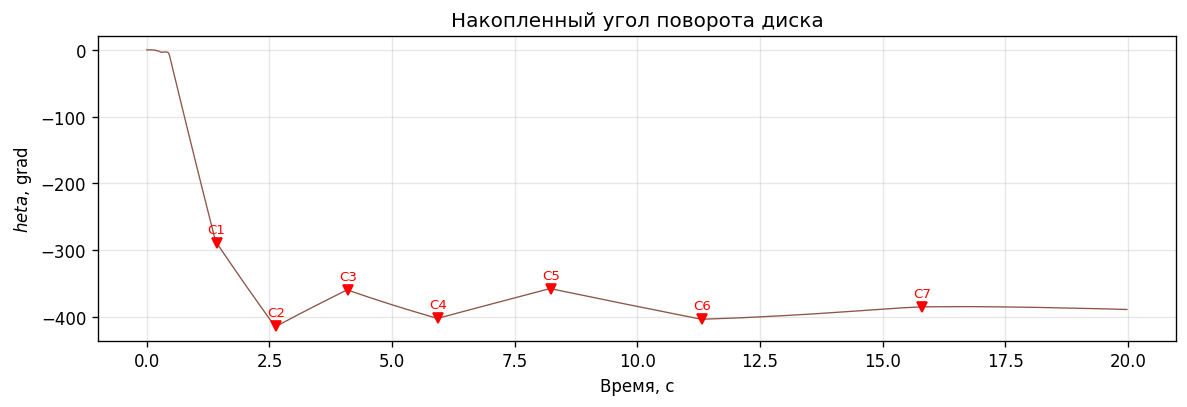

In [6]:
dt = 0.02
df['theta_deg'] = np.cumsum(df['gz_dps'] * dt)
df['theta_rad'] = np.radians(df['theta_deg'])
df['ax_lab'] = df['ax_g'] * np.cos(df['theta_rad']) - df['ay_g'] * np.sin(df['theta_rad'])
df['ay_lab'] = df['ax_g'] * np.sin(df['theta_rad']) + df['ay_g'] * np.cos(df['theta_rad'])

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(df['time_s'], df['theta_deg'], lw=0.8, color='C5')
for i, grp in enumerate(collisions):
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    t = df.loc[peak_idx, 'time_s']
    th = df.loc[peak_idx, 'theta_deg']
    ax.plot(t, th, 'rv', ms=6)
    ax.text(t, th + 15, f'C{i+1}', ha='center', fontsize=8, color='red')
ax.set_xlabel('Время, с'); ax.set_ylabel('$\theta$, grad')
ax.set_title('Накопленный угол поворота диска')
plt.tight_layout(); plt.show()


## 5. Параметры столкновений

In [7]:
results = []
for i, grp in enumerate(collisions):
    peak_idx = df.loc[grp, 'a_xy'].idxmax()
    peak_a = df.loc[peak_idx, 'a_xy']
    peak_t = df.loc[peak_idx, 'time_s']
    theta_body = np.degrees(np.arctan2(df.loc[peak_idx, 'ay_g'], df.loc[peak_idx, 'ax_g']))
    theta_lab = np.degrees(np.arctan2(df.loc[peak_idx, 'ay_lab'], df.loc[peak_idx, 'ax_lab']))
    b_s, b_e = max(0, grp[0]-10), grp[0]-1
    a_s, a_e = grp[-1]+2, min(len(df)-1, grp[-1]+10)
    gz_b = np.mean(df.loc[b_s:b_e, 'gz_dps'])
    gz_a = np.mean(df.loc[a_s:a_e, 'gz_dps'])
    sign_flip = np.sign(gz_b) != np.sign(gz_a)
    ke_r = (gz_a/gz_b)**2 if abs(gz_b) > 0.5 else np.nan
    results.append([i+1, round(peak_t,3), round(peak_a,2), round(theta_body,1), 
                    round(theta_lab,1), round(gz_b,1), round(gz_a,1), 
                    round(gz_a-gz_b,1), 'da' if sign_flip else '', 
                    round(ke_r,3) if not np.isnan(ke_r) else None])

params = pd.DataFrame(results, columns=['#','t','|a|,g','theta_disk','theta_lab',
    'w_before','w_after','dw','sign_flip','KE_ratio'])
params


,#,t,"|a|,g",theta_disk,theta_lab,w_before,w_after,dw,sign_flip,KE_ratio
0,1,1.42,10.27,163.0,-125.6,-289.8,-108.3,181.5,,0.140
1,2,2.64,5.69,105.9,52.2,-102.1,39.2,141.4,da,0.148
2,3,4.10,5.95,-124.7,-124.5,36.9,-25.1,-62.0,da,0.461
3,4,5.94,2.72,84.3,42.6,-21.6,19.9,41.5,da,0.844
4,5,8.24,3.17,-121.1,-118.8,19.2,-14.9,-34.0,da,0.602
5,6,11.32,1.31,89.1,45.9,-14.4,2.6,17.0,da,0.033
6,7,15.80,2.73,-97.6,-122.3,3.8,0.4,-3.4,,0.011


**Ключевые наблюдения:**
- **theta_disk** хаотично — артефакт вращения СК.
- **theta_lab** чередуется: ~45° и ~−120° — **два кластера = две стенки**.
- В 5 из 7 столкновений знак $\omega$ меняется — тангенциальный импульс от струны.

> **Методологическое замечание:** без пересчёта в лабораторную СК через интегрирование $\omega_z$
> вывод о чередовании направлений был бы некорректным.


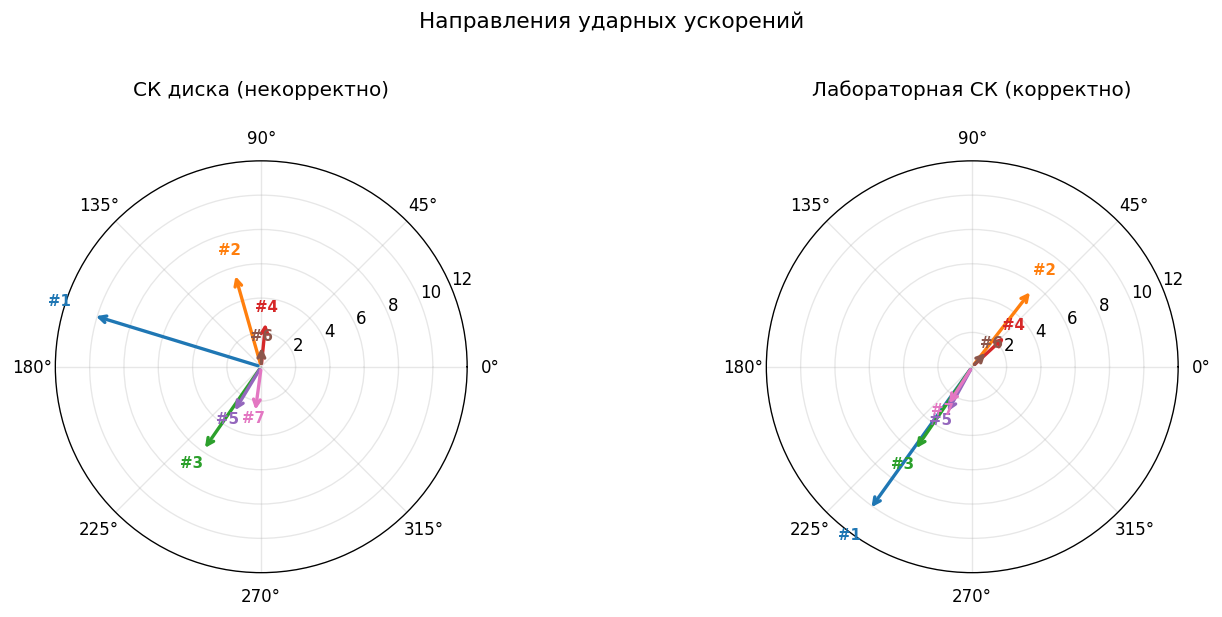

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': 'polar'})
for ax, frame, title in [(axes[0], 'body', 'СК диска (некорректно)'), 
                          (axes[1], 'lab', 'Лабораторная СК (корректно)')]:
    for i, grp in enumerate(collisions):
        pk = df.loc[grp, 'a_xy'].idxmax()
        if frame == 'body':
            axp, ayp = df.loc[pk, 'ax_g'], df.loc[pk, 'ay_g']
        else:
            axp, ayp = df.loc[pk, 'ax_lab'], df.loc[pk, 'ay_lab']
        a_mag = np.sqrt(axp**2 + ayp**2)
        th = np.arctan2(ayp, axp)
        ax.annotate('', xy=(th, a_mag), xytext=(0, 0),
                    arrowprops=dict(arrowstyle='->', color=f'C{i}', lw=2))
        ax.text(th, a_mag*1.2, f'#{i+1}', ha='center', fontsize=9, fontweight='bold', color=f'C{i}')
    ax.set_title(title, pad=20); ax.set_rmax(12)
plt.suptitle('Направления ударных ускорений', fontsize=13, y=1.02)
plt.tight_layout(); plt.show()


## 6. Модель вращательного трения

Между столкновениями диск испытывает только трение о воздух. 
Измеряем угловое замедление |alpha| и среднюю |omega| на каждом тихом сегменте.


In [9]:
def get_quiet_segments(df, launch_event, collisions, margin=5, min_len=15):
    segments = []
    s0_start = launch_event[-1] + margin
    s0_end = collisions[0][0] - margin
    if s0_end - s0_start >= min_len:
        segments.append(('После запуска', s0_start, s0_end))
    for i in range(len(collisions)):
        start = collisions[i][-1] + margin
        end = collisions[i+1][0] - margin if i < len(collisions)-1 else len(df)-1
        if end - start >= min_len:
            segments.append((f'После C{i+1}', start, end))
    return segments

segments = get_quiet_segments(df, launch_event, collisions)
omega_abs_list, alpha_abs_list, seg_labels = [], [], []

for label, i_start, i_end in segments:
    seg = df.iloc[i_start:i_end+1]
    t, gz = seg['time_s'].values, seg['gz_dps'].values
    slope = np.polyfit(t, gz, 1)[0]
    gz_mean = np.mean(gz)
    print(f"{label:<18} t={t[0]:.2f}-{t[-1]:.2f}  <w>={gz_mean:>7.1f}  alpha={slope:>7.2f}")
    if abs(gz_mean) > 3:
        omega_abs_list.append(abs(gz_mean))
        alpha_abs_list.append(abs(slope))
        seg_labels.append(label)

omega_arr, alpha_arr = np.array(omega_abs_list), np.array(alpha_abs_list)


После запуска      t=0.58-1.32  <w>= -296.2  alpha=  17.12
После C1           t=1.52-2.52  <w>= -105.1  alpha=   6.49
После C2           t=2.74-4.00  <w>=   37.7  alpha=  -2.07
После C3           t=4.20-5.84  <w>=  -23.2  alpha=   2.31
После C4           t=6.06-8.14  <w>=   19.5  alpha=  -0.21
После C5           t=8.34-11.22  <w>=  -14.9  alpha=   0.17
После C6           t=11.42-15.70  <w>=    4.2  alpha=   0.50
После C7           t=15.90-19.98  <w>=   -1.0  alpha=  -0.67


Фит: |alpha| = 0.05841 * |omega| + (-0.054)
  k = 0.05841 1/с,  tau = 17.1 с
  Кулоновская добавка: -0.054 (пренебрежимо мала)


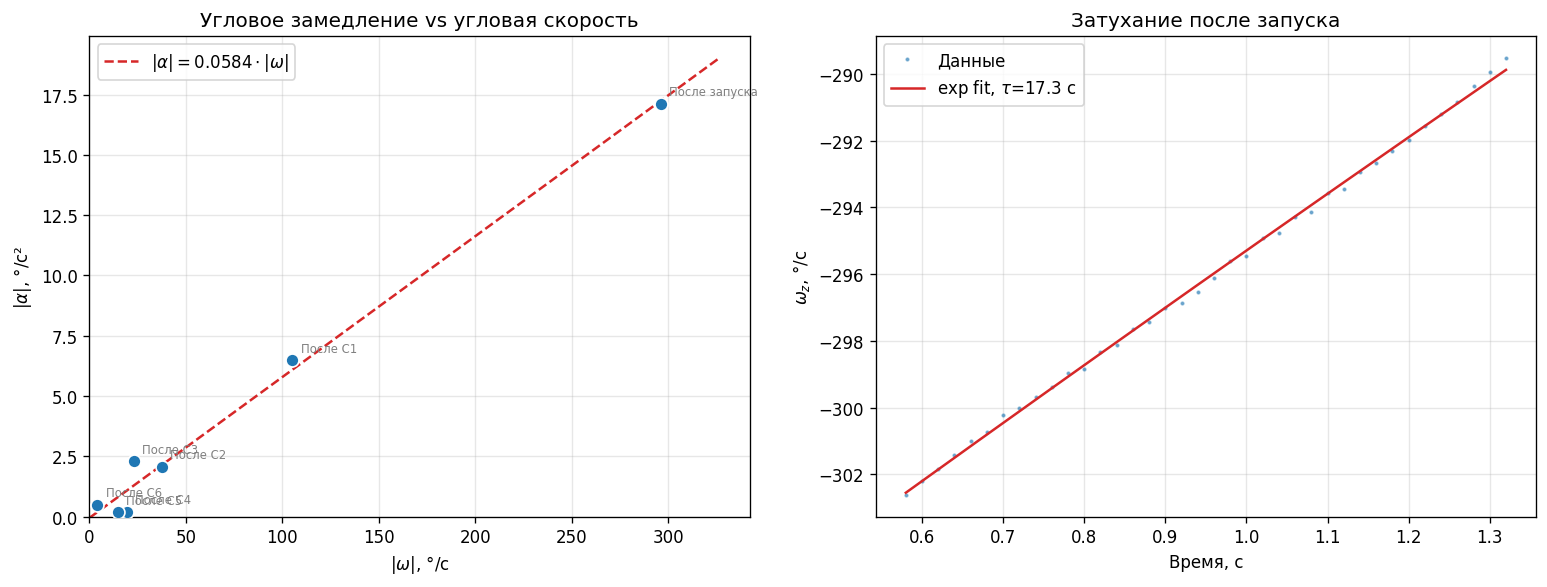

In [10]:
k_visc, k_coul = np.polyfit(omega_arr, alpha_arr, 1)
print(f"Фит: |alpha| = {k_visc:.5f} * |omega| + ({k_coul:.3f})")
print(f"  k = {k_visc:.5f} 1/с,  tau = {1/k_visc:.1f} с")
print(f"  Кулоновская добавка: {k_coul:.3f} (пренебрежимо мала)")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
ax = axes[0]
ax.scatter(omega_arr, alpha_arr, s=60, zorder=5, color='C0', edgecolors='white')
for j, lbl in enumerate(seg_labels):
    ax.annotate(lbl, (omega_arr[j], alpha_arr[j]), fontsize=7, xytext=(5,5), textcoords='offset points', color='gray')
wf = np.linspace(0, omega_arr.max()*1.1, 100)
ax.plot(wf, k_visc*wf + k_coul, 'C3--', lw=1.5, label=r'$|\alpha|=%.4f\cdot|\omega|$' % k_visc)
ax.set_xlabel(r'$|\omega|$, °/с'); ax.set_ylabel(r'$|\alpha|$, °/с²')
ax.set_title('Угловое замедление vs угловая скорость')
ax.set_xlim(0); ax.set_ylim(0); ax.legend()

ax = axes[1]
seg = df.iloc[segments[0][1]:segments[0][2]+1]
ts, gs = seg['time_s'].values, seg['gz_dps'].values
def exp_decay(t, w0, tau, t0): return w0*np.exp(-(t-t0)/tau)
popt, _ = curve_fit(exp_decay, ts, gs, p0=[gs[0], 17, ts[0]])
tf = np.linspace(ts[0], ts[-1], 200)
ax.plot(ts, gs, '.', ms=3, alpha=0.5, label='Данные')
ax.plot(tf, exp_decay(tf, *popt), 'C3-', lw=1.5, label=r'exp fit, $\tau$=%.1f с' % popt[1])
ax.set_xlabel('Время, с'); ax.set_ylabel(r'$\omega_z$, °/с')
ax.set_title('Затухание после запуска'); ax.legend()
plt.tight_layout(); plt.show()


### Результат

$$\boxed{\frac{d\omega}{dt} = -\frac{\omega}{\tau}, \quad \tau \approx 17 \text{ с}}$$

Чисто **вязкая модель**. Кулоновская компонента пренебрежимо мала.

## 7. Тангенциальный импульс при столкновении


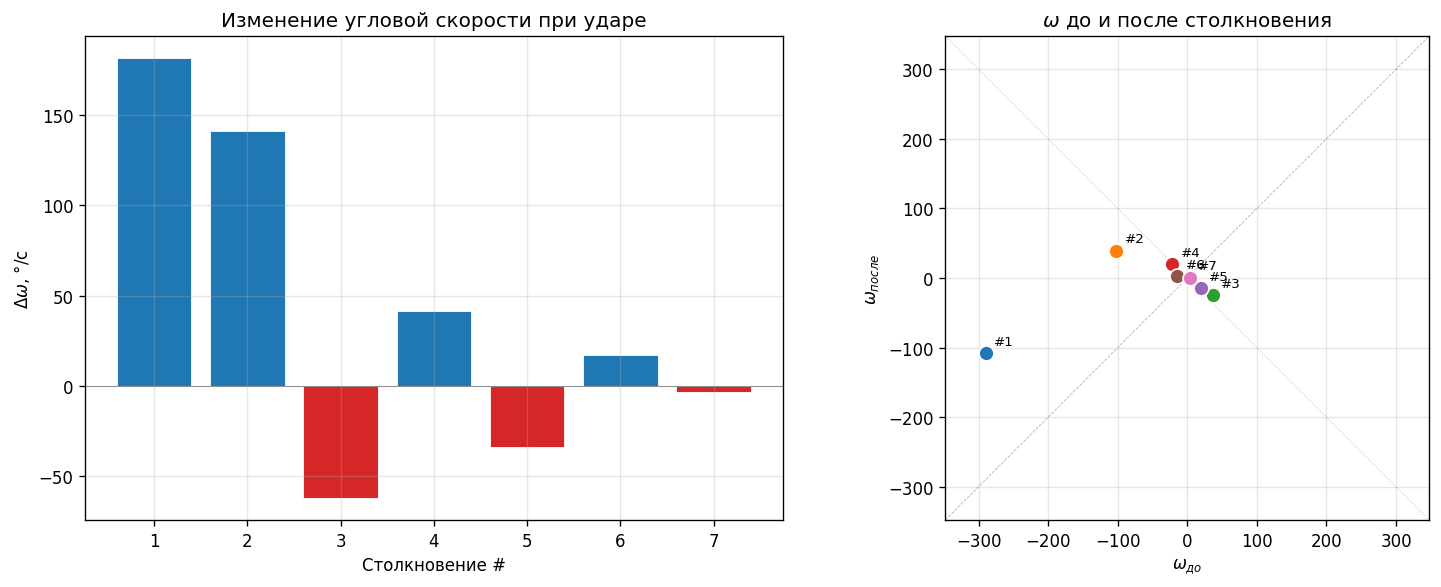

In [11]:
gz_before_list, gz_after_list = [], []
for grp in collisions:
    b_s, b_e = max(0, grp[0]-10), grp[0]-1
    a_s, a_e = grp[-1]+2, min(len(df)-1, grp[-1]+10)
    gz_before_list.append(np.mean(df.loc[b_s:b_e, 'gz_dps']))
    gz_after_list.append(np.mean(df.loc[a_s:a_e, 'gz_dps']))

dw = np.array(gz_after_list) - np.array(gz_before_list)
x = np.arange(1, len(collisions)+1)
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.bar(x, dw, color=['C0' if d>0 else 'C3' for d in dw], edgecolor='white', lw=0.5)
ax.set_xlabel('Столкновение #'); ax.set_ylabel(r'$\Delta\omega$, °/с')
ax.set_title('Изменение угловой скорости при ударе')
ax.axhline(0, color='gray', lw=0.5); ax.set_xticks(x)

ax = axes[1]
gb, ga = np.array(gz_before_list), np.array(gz_after_list)
for i in range(len(collisions)):
    ax.scatter(gb[i], ga[i], s=80, zorder=5, c=f'C{i}', edgecolors='white')
    ax.annotate(f'#{i+1}', (gb[i], ga[i]), fontsize=8, xytext=(5,5), textcoords='offset points')
lim = max(abs(gb).max(), abs(ga).max())*1.2
ax.plot([-lim,lim],[-lim,lim], 'k--', lw=0.5, alpha=0.3)
ax.plot([-lim,lim],[lim,-lim], 'k:', lw=0.5, alpha=0.3)
ax.set_xlabel(r'$\omega_{до}$'); ax.set_ylabel(r'$\omega_{после}$')
ax.set_title(r'$\omega$ до и после столкновения')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_aspect('equal')
plt.tight_layout(); plt.show()


## 8. Потери вращательной кинетической энергии

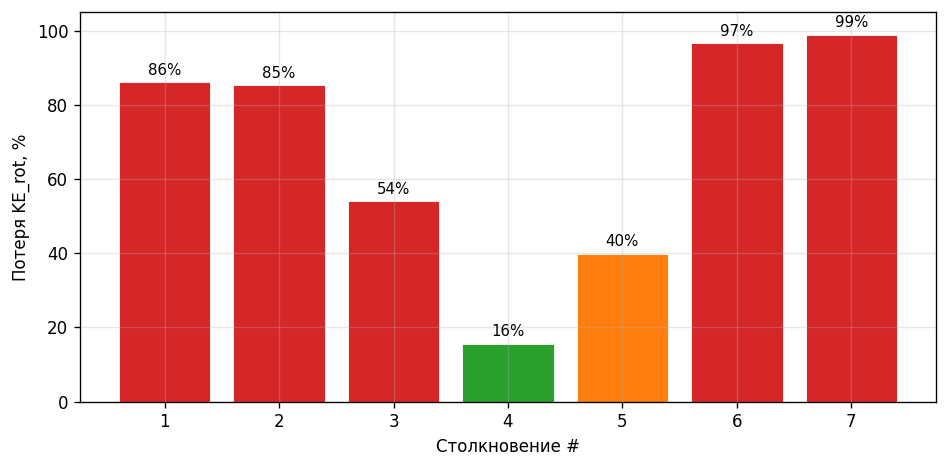

Потери 16-98% — нет единого коэффициента восстановления.


In [12]:
ke_loss = 1 - (np.array(gz_after_list)**2) / (np.array(gz_before_list)**2)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x, ke_loss*100, color=['C3' if l>0.5 else 'C1' if l>0.2 else 'C2' for l in ke_loss],
       edgecolor='white', lw=0.5)
ax.set_xlabel('Столкновение #'); ax.set_ylabel('Потеря KE_rot, %')
ax.set_xticks(x); ax.set_ylim(0, 105)
for i, v in enumerate(ke_loss):
    ax.text(i+1, v*100+2, f'{v*100:.0f}%', ha='center', fontsize=9)
plt.tight_layout(); plt.show()
print("Потери 16-98% — нет единого коэффициента восстановления.")


## 9. Замедление поступательного движения

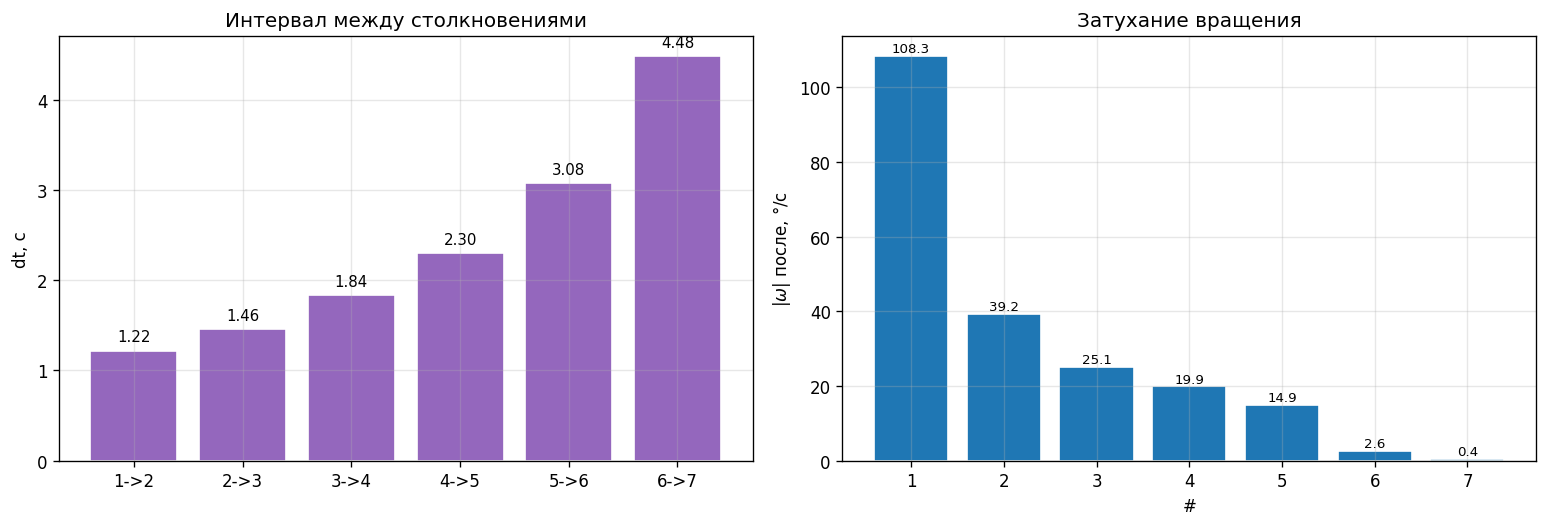

Рост интервалов в 3.7 раза — поступательное замедление


In [13]:
ct = [df.loc[df.loc[grp, 'a_xy'].idxmax(), 'time_s'] for grp in collisions]
dt_b = np.diff(ct)
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
ax.bar([f'{i+1}->{i+2}' for i in range(len(dt_b))], dt_b, color='C4', edgecolor='white')
ax.set_ylabel('dt, с'); ax.set_title('Интервал между столкновениями')
for i, v in enumerate(dt_b): ax.text(i, v+0.1, f'{v:.2f}', ha='center', fontsize=9)

ax = axes[1]
wa = [abs(g) for g in gz_after_list]
ax.bar(x, wa, color='C0', edgecolor='white')
ax.set_xlabel('#'); ax.set_ylabel(r'$|\omega|$ после, °/с')
ax.set_title('Затухание вращения')
for i, v in enumerate(wa): ax.text(i+1, v+1, f'{v:.1f}', ha='center', fontsize=8)
plt.tight_layout(); plt.show()
print(f"Рост интервалов в {dt_b[-1]/dt_b[0]:.1f} раза — поступательное замедление")


## 10. Сводка количественных результатов

| Параметр | Значение | Комментарий |
|----------|---------|-------------|
| Модель трения | $\alpha = -\omega / \tau$ | Чисто вязкое |
| $\tau$ | **17.1 с** | Кулоновская компонента $\approx 0$ |
| Столкновений | **7** | Запуск рукой исключён |
| Пиковые ускорения | 1.3 – 10.3 g | |
| Длительность контакта | $\leq$ 40 мс | Ограничена частотой 50 Гц |
| Смена знака $\omega$ | **5 из 7** | Тангенциальный импульс |
| Потери $KE_{rot}$ | 16% – 98% | Зависят от геометрии контакта |
| Рост $\Delta t$ | 1.22 → 4.48 с ($\times 3.7$) | Замедление поступательного движения |
| Направления (лаб. СК) | ~45° / ~−120° | Два кластера — две стенки |

### Методологическое замечание

Акселерометр измеряет в **подвижной СК диска**. Для направлений ударов необходим 
**пересчёт в лабораторную систему** через интегрирование $\omega_z$. 
Без пересчёта кажущаяся закономерность может быть артефактом вращения СК.

### Возможные расширения
- **Два IMU / камера:** линейная скорость → полный энергобаланс
- **Частота ≥ 1 кГц:** форма ударного импульса  
- **Масса и момент инерции:** абсолютные энергии и импульсы
